name - ch. surya


usn - 21btrcl025

### 1.Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [2]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [5]:
images = tf.data.Dataset.list_files('C:\\Users\\chsur\\cv\data\\images\\*.jpg')

In [6]:
images.as_numpy_iterator().next()

b'C:\\Users\\chsur\\cv\\data\\images\\IMG20221004161838.jpg'

In [7]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [8]:
images = images.map(load_image)

In [9]:
images.as_numpy_iterator().next()

array([[[120,  51,  56],
        [ 90,  31,  33],
        [ 87,  47,  47],
        ...,
        [136,  62,  23],
        [137,  65,  27],
        [137,  65,  27]],

       [[112,  43,  48],
        [ 92,  33,  35],
        [ 86,  46,  46],
        ...,
        [136,  62,  23],
        [140,  68,  30],
        [142,  70,  32]],

       [[103,  37,  41],
        [ 98,  39,  41],
        [ 94,  54,  54],
        ...,
        [148,  76,  36],
        [153,  81,  41],
        [155,  83,  43]],

       ...,

       [[112, 117,  76],
        [ 94,  99,  58],
        [ 79,  84,  43],
        ...,
        [181, 178, 169],
        [181, 178, 169],
        [180, 177, 168]],

       [[ 80,  83,  40],
        [ 87,  90,  47],
        [ 88,  94,  50],
        ...,
        [179, 176, 167],
        [179, 176, 167],
        [178, 175, 166]],

       [[ 88,  91,  48],
        [103, 106,  63],
        [117, 123,  79],
        ...,
        [179, 176, 167],
        [179, 176, 167],
        [178, 175, 166]]

In [10]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [11]:
#image_generator = images.batch(4).as_numpy_iterator()

In [15]:
image_generator = images.batch(32).as_numpy_iterator()
plot_images = image_generator.next()

InvalidArgumentError: {{function_node __wrapped__IteratorGetNext_output_types_1_device_/job:localhost/replica:0/task:0/device:CPU:0}} Cannot add tensor to the batch: number of elements does not match. Shapes are: [tensor]: [4624,3468,3], [batch]: [2600,4624,3] [Op:IteratorGetNext] name: 

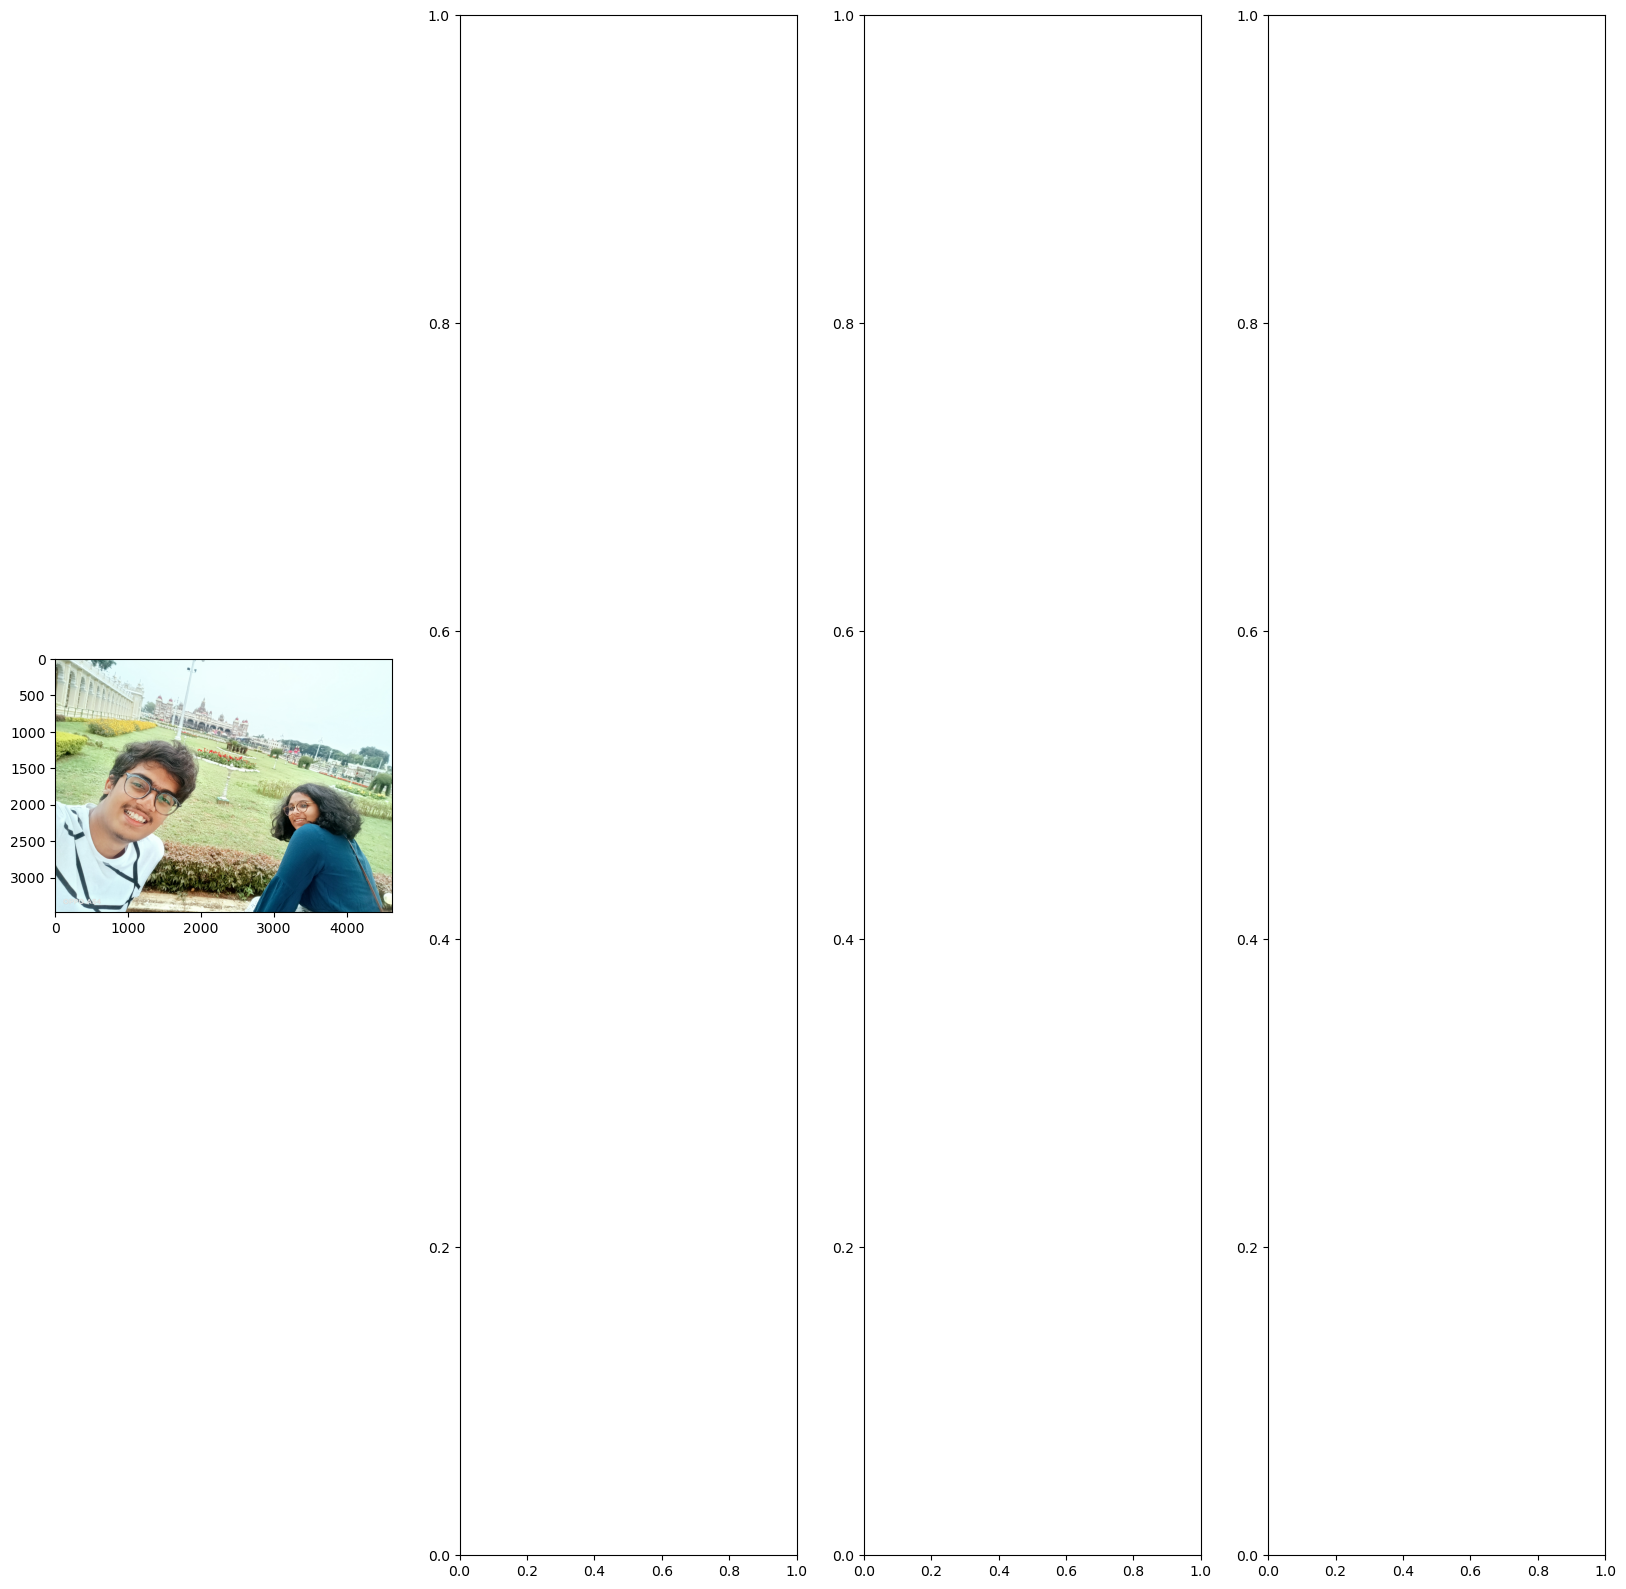

In [16]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
    plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [14]:
300*.7 # 63 to train

210.0

In [15]:
300*.15 # 14 and 13 to test and val

45.0

### 3.2 Move the Matching Labels

In [16]:
import os
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('C:\\Users\\chsur\\cv\\data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('C:\\Users\\chsur\\cv\\data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('C:\\Users\\chsur\\cv\\data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [17]:
import albumentations as alb

In [18]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [19]:
img = cv2.imread(os.path.join('C:\\Users\\chsur\\cv\\data','train', 'images','IMG-20221007-WA0145.jpg'))

In [20]:
with open(os.path.join('C:\\Users\\chsur\\cv\\data', 'train', 'labels', 'IMG-20221007-WA0145.json'), 'r') as f:
    label = json.load(f)

In [45]:
label['shapes'][0]['points']

[[195.11111111111086, 1300.8888888888887],
 [2711.7777777777774, 4256.444444444444]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [46]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [47]:
coords

[195.11111111111086, 1300.8888888888887, 2711.7777777777774, 4256.444444444444]

In [48]:
coords = list(np.divide(coords, [640,680,640,580]))

In [49]:
coords

[0.3048611111111107, 1.9130718954248362, 4.237152777777777, 7.338697318007663]

In [28]:

# Assuming you have an image 'img' and bounding box coordinates 'coords'
# coords = [x_min, y_min, x_max, y_max]

# Normalize the bounding box coordinates
image_width = 640
image_height = 480
normalized_coords = np.divide(coords, [image_width, image_height, image_width, image_height])

# Create an augmentation pipeline (you can customize this as needed)
  # Example augmentation
    # Add more augmentations here


# Augment the image with the bounding box
augmented = augmentor(image=img, bboxes=[coords], class_labels=['SURYA'])


In [29]:
augmented

{'image': array([[[ 76,  76,  68],
         [ 72,  70,  62],
         [ 72,  70,  62],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 70,  68,  60],
         [ 70,  69,  58],
         [ 70,  69,  58],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 70,  68,  60],
         [ 70,  69,  58],
         [ 72,  68,  58],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[105, 110, 111],
         [ 56,  61,  62],
         [ 42,  47,  48],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 41,  46,  47],
         [ 42,  47,  48],
         [ 45,  50,  51],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[ 58,  62,  60],
         [ 15,  18,  16],
         [ 95,  99,  97],
         ...,
         [255, 255,

### 4.4 Apply Augmentations and View Results

In [30]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['SURYA'])

In [31]:
augmented


{'image': array([[[ 42,  47,  38],
         [ 42,  47,  38],
         [ 43,  48,  39],
         ...,
         [221, 241, 246],
         [225, 245, 250],
         [230, 250, 255]],
 
        [[ 41,  46,  37],
         [ 42,  47,  38],
         [ 42,  47,  38],
         ...,
         [227, 247, 252],
         [229, 248, 253],
         [229, 248, 253]],
 
        [[ 45,  51,  40],
         [ 46,  52,  41],
         [ 47,  53,  42],
         ...,
         [227, 243, 249],
         [228, 244, 250],
         [229, 246, 249]],
 
        ...,
 
        [[ 62,  57,  54],
         [ 62,  59,  55],
         [ 64,  61,  57],
         ...,
         [253, 255, 255],
         [253, 255, 255],
         [253, 255, 255]],
 
        [[ 62,  57,  54],
         [ 62,  59,  55],
         [ 64,  61,  57],
         ...,
         [253, 255, 255],
         [253, 255, 255],
         [253, 255, 255]],
 
        [[ 62,  57,  56],
         [ 62,  58,  57],
         [ 64,  60,  59],
         ...,
         [253, 255,

In [32]:
augmented['bboxes'][0][2:]

IndexError: list index out of range

In [34]:
augmented['bboxes']

[]

In [35]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)), 
              (255,0,0), 2)

plt.imshow(augmented['image'])

IndexError: list index out of range

In [36]:
if augmented['bboxes']:
    # Access the bounding box coordinates
    bbox = augmented['bboxes'][0]
    # Rest of your code...
else:
    print("No bounding boxes found in the augmented data.")


No bounding boxes found in the augmented data.


# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [44]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('C:\\Users\\chsur\\cv\\data', partition, 'images')):
        img = cv2.imread(os.path.join('C:\\Users\\chsur\\cv\\data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('C:\\Users\\chsur\\cv\\data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('C:\\Users\\chsur\\cv\\aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('C:\\Users\\chsur\\cv\\aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

Expected y_min for bbox [0.9526785714285708, 2.4702380952380953, 1.9422619047619043, 4.0773809523809526, 'face'] to be in the range [0.0, 1.0], got 2.4702380952380953.
Expected x_max for bbox [0.6134259259259258, 0.91820987654321, 1.3483796296296295, 2.0871913580246915, 'face'] to be in the range [0.0, 1.0], got 1.3483796296296295.
Expected y_min for bbox [0.6242559523809523, 1.0337301587301588, 0.719122023809524, 1.1701388888888888, 'face'] to be in the range [0.0, 1.0], got 1.0337301587301588.
Expected y_max for bbox [0.7181743421052632, 0.9669956140350877, 0.9936677631578947, 1.4467105263157893, 'face'] to be in the range [0.0, 1.0], got 1.4467105263157893.
Expected y_min for bbox [0.7716282894736841, 1.0601973684210526, 1.0388980263157896, 1.5563596491228069, 'face'] to be in the range [0.0, 1.0], got 1.0601973684210526.
Expected y_min for bbox [0.8127467105263155, 1.019078947368421, 1.0738486842105261, 1.5070175438596491, 'face'] to be in the range [0.0, 1.0], got 1.01907894736842

Expected y_max for bbox [0.7928240740740741, 0.7330246913580247, 0.9664351851851851, 1.0609567901234567, 'face'] to be in the range [0.0, 1.0], got 1.0609567901234567.
Expected x_min for bbox [1.1160714285714286, 0.22321428571428573, 1.2627551020408165, 0.4719387755102041, 'face'] to be in the range [0.0, 1.0], got 1.1160714285714286.
Expected x_min for bbox [4.424189814814815, 0.4665895061728397, 4.895833333333333, 1.2304783950617284, 'face'] to be in the range [0.0, 1.0], got 4.424189814814815.
Expected x_min for bbox [2.2635912698412697, 2.6650132275132274, 2.5562499999999995, 3.1081349206349205, 'face'] to be in the range [0.0, 1.0], got 2.2635912698412697.
Expected x_min for bbox [2.2080357142857143, 2.7113095238095237, 2.487053571428571, 3.1547619047619047, 'face'] to be in the range [0.0, 1.0], got 2.2080357142857143.
Expected x_min for bbox [1.9416330645161293, 1.7701612903225803, 3.267237903225807, 3.954301075268817, 'face'] to be in the range [0.0, 1.0], got 1.941633064516129

Expected x_min for bbox [2.7875, 2.339814814814815, 4.514930555555555, 4.781944444444445, 'face'] to be in the range [0.0, 1.0], got 2.7875.
Expected x_min for bbox [2.63125, 1.460185185185185, 4.254513888888889, 4.295833333333333, 'face'] to be in the range [0.0, 1.0], got 2.63125.
Expected x_min for bbox [2.561805555555556, 2.293518518518518, 4.150347222222222, 4.920833333333333, 'face'] to be in the range [0.0, 1.0], got 2.561805555555556.
Expected x_min for bbox [2.6486111111111112, 7.258796296296296, 4.020138888888889, 5.256481481481481, 'face'] to be in the range [0.0, 1.0], got 2.6486111111111112.
Expected x_min for bbox [3.875, 2.129166666666667, 5.9875, 3.995833333333333, 'face'] to be in the range [0.0, 1.0], got 3.875.
Expected x_min for bbox [4.575, 2.7041666666666666, 5.88125, 4.545833333333333, 'face'] to be in the range [0.0, 1.0], got 4.575.
Expected x_min for bbox [2.405555555555556, 4.7935185185185185, 3.481944444444445, 6.286574074074074, 'face'] to be in the range [

Expected x_min for bbox [4.1625, 1.2791666666666666, 5.80625, 3.7041666666666666, 'face'] to be in the range [0.0, 1.0], got 4.1625.
Expected y_min for bbox [0.6125, 1.6375, 2.1, 4.0125, 'face'] to be in the range [0.0, 1.0], got 1.6375.
Expected y_min for bbox [0.75, 1.7625, 2.10625, 4.129166666666666, 'face'] to be in the range [0.0, 1.0], got 1.7625.
Expected x_min for bbox [1.16875, 1.7708333333333333, 2.48125, 4.179166666666666, 'face'] to be in the range [0.0, 1.0], got 1.16875.
Expected x_min for bbox [1.6764705882352942, 1.2659313725490196, 2.068014705882353, 1.946078431372549, 'face'] to be in the range [0.0, 1.0], got 1.6764705882352942.
Expected x_min for bbox [1.656003937007874, 1.6141732283464567, 2.0361712598425195, 2.309711286089239, 'face'] to be in the range [0.0, 1.0], got 1.656003937007874.
Expected y_min for bbox [0.5507305194805194, 1.5894480519480518, 0.9342532467532466, 2.2631493506493503, 'face'] to be in the range [0.0, 1.0], got 1.5894480519480518.
Expected y_

Expected x_min for bbox [2.6215277777777772, 4.874537037037038, 3.897569444444444, 7.224074074074074, 'face'] to be in the range [0.0, 1.0], got 2.6215277777777772.
Expected x_min for bbox [5.038911290322581, 0.020161290322580634, 6.616532258064517, 2.244623655913978, 'face'] to be in the range [0.0, 1.0], got 5.038911290322581.
Expected x_min for bbox [4.053819444444445, 2.339814814814815, 2.3611111111111116, 6.055092592592592, 'face'] to be in the range [0.0, 1.0], got 4.053819444444445.
Expected x_min for bbox [1.0763888888888886, 4.353703703703704, 2.5, 6.818981481481481, 'face'] to be in the range [0.0, 1.0], got 1.0763888888888886.
Expected y_min for bbox [0.15625, 3.948611111111111, 1.684027777777778, 6.622222222222222, 'face'] to be in the range [0.0, 1.0], got 3.948611111111111.
Expected y_min for bbox [0.017361111111110716, 3.902314814814815, 1.328125, 6.448611111111111, 'face'] to be in the range [0.0, 1.0], got 3.902314814814815.
Expected y_min for bbox [0.22569444444444428

Expected x_min for bbox [3.307291666666667, 4.816666666666666, 1.6927083333333335, 6.842129629629629, 'face'] to be in the range [0.0, 1.0], got 3.307291666666667.
Expected x_min for bbox [1.7727822580645163, 0.9744623655913979, 3.355443548387097, 3.0712365591397845, 'face'] to be in the range [0.0, 1.0], got 1.7727822580645163.
Expected x_min for bbox [4.027777777777777, 4.631481481481481, 2.803819444444444, 6.842129629629629, 'face'] to be in the range [0.0, 1.0], got 4.027777777777777.
Expected x_min for bbox [5.547983870967743, 0.0336021505376344, 4.156854838709678, 2.4596774193548385, 'face'] to be in the range [0.0, 1.0], got 5.547983870967743.
Expected x_min for bbox [2.447916666666667, 4.562037037037038, 3.741319444444444, 6.506481481481481, 'face'] to be in the range [0.0, 1.0], got 2.447916666666667.
Expected x_min for bbox [2.395833333333333, 4.492592592592592, 3.645833333333333, 6.483333333333333, 'face'] to be in the range [0.0, 1.0], got 2.395833333333333.
Expected x_min 

### 5.2 Load Augmented Images to Tensorflow Dataset

In [39]:
train_images = tf.data.Dataset.list_files('C:\\Users\\chsur\\cv\\aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [40]:
test_images = tf.data.Dataset.list_files('C:\\Users\\chsur\\cv\\aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: C:\\Users\\chsur\\cv\\aug_data\\test\\images\\*.jpg'

In [41]:
val_images = tf.data.Dataset.list_files('C:\\Users\\chsur\\cv\\aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [42]:
train_images.as_numpy_iterator().next()

array([[[0.77248776, 0.79601717, 0.79601717],
        [0.7857843 , 0.8088235 , 0.8102941 ],
        [0.7882353 , 0.8039216 , 0.8156863 ],
        ...,
        [0.8122549 , 0.847549  , 0.84362745],
        [0.8117647 , 0.84705883, 0.84313726],
        [0.8117647 , 0.84705883, 0.84313726]],

       [[0.7769608 , 0.8004902 , 0.8004902 ],
        [0.78186274, 0.8018995 , 0.81237745],
        [0.7887255 , 0.80441177, 0.8161765 ],
        ...,
        [0.8122549 , 0.84362745, 0.8514706 ],
        [0.8117647 , 0.84313726, 0.8509804 ],
        [0.8117647 , 0.84313726, 0.8509804 ]],

       [[0.8029412 , 0.8264706 , 0.8264706 ],
        [0.8112745 , 0.83480394, 0.83480394],
        [0.7970588 , 0.8127451 , 0.8245098 ],
        ...,
        [0.8126838 , 0.84797794, 0.84405637],
        [0.811826  , 0.8471201 , 0.84319854],
        [0.80833334, 0.84362745, 0.8397059 ]],

       ...,

       [[0.5251838 , 0.5526348 , 0.5918505 ],
        [0.39375   , 0.421201  , 0.46041667],
        [0.36237746, 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [ ]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [ ]:
train_labels = tf.data.Dataset.list_files('C:\\Users\\chsur\\cv\\aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
test_labels = tf.data.Dataset.list_files('C:\\Users\\chsur\\cv\\aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
val_labels = tf.data.Dataset.list_files('C:\\Users\\chsur\\cv\\aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [ ]:
train_labels.as_numpy_iterator().next()

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [ ]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

### 7.2 Create Final Datasets (Images/Labels)

In [ ]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [ ]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [ ]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [ ]:
train.as_numpy_iterator().next()[1]

### 7.3 View Images and Annotations

In [ ]:
data_samples = train.as_numpy_iterator()

In [ ]:
res = data_samples.next()

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [ ]:
vgg = VGG16(include_top=False)

In [ ]:
vgg.summary()

### 8.3 Build instance of Network

In [ ]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [ ]:
facetracker = build_model()

In [ ]:
facetracker.summary()

In [ ]:
X, y = train.as_numpy_iterator().next()

In [ ]:
X.shape

In [ ]:
classes, coords = facetracker.predict(X)

In [ ]:
classes, coords

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [ ]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [ ]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [ ]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [ ]:
localization_loss(y[1], coords)

In [ ]:
classloss(y[0], classes)

In [ ]:
regressloss(y[1], coords)

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [ ]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [ ]:
model = FaceTracker(facetracker)

In [ ]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [ ]:
logdir='logs'

In [ ]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

### 10.3 Plot Performance

In [ ]:
hist.history

In [ ]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [ ]:
test_data = test.as_numpy_iterator()

In [ ]:
test_sample = test_data.next()

In [ ]:
yhat = facetracker.predict(test_sample[0])

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('facetracker.h5')

In [ ]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(1)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()